# Attention is All You Need

The *Transformer* architecture ([Vaswani et al., 2017](https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html)) and its attention mechanism is the most influential breakthrough in modern natural language processing. Similarly to variational auto-encoders ([Kingma et al., 2013](https://arxiv.org/abs/1312.6114)), it consists of two parts:

1. an **Encoder** used for "understanding" language and
2. a **Decoder** used for generating language.

But not all Transformers use an encoder-decoder architecture. For example, (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) BERT([Devlin et al., 2019](https://arxiv.org/abs/1810.04805)) is an encoder-only Transformer that is trained to learn semantic vector-representations for words based on the context they occur in, so called *contextual embeddings*.

A notable encoder-decoder Transformer is T5, and GPT is a decoder-only Transformer. GPT may also be the most prominent Transformer model right now due to its proficiency at generating natural language text, though various more Transformer architectures have since been published. But they all follow a similar basic setup.

## Static Embeddings

> You shall know a word by the company it keeps. &mdash; *John R. Firth*

Deep Learning models cannot operate on strings of characters but only on numbers. Inherently, this means that, to process textual inputs, we need some way to map the text to a number representation. This is usually done in two steps:
1. **Tokenization** &ndash; the text is split into semantic units ("tokens") such as words, [morphemes](https://en.wikipedia.org/wiki/Morpheme), characters, bytes, ...
2. **Embedding** &ndash; each semantic unit is embedded into the same vector space

Tokenization algorithms in this context must be able to map arbitrary text onto a finite set of tokens. E.g., for word tokenization this may mean that some words are dropped because they are not part of the vocabulary.
The latter step, embedding, is where the magic happens: Theoretically, it would be sufficient, to simply assign a unique number to each token and pray that the model learns meaning in some form. However, there is a better alternative, so called *semantic embeddings*.


A famous semantic embedding model is *word2vec* ([Mikolov et al., 2013](https://arxiv.org/pdf/1301.3781)). There are various ways to train such a model and we will refer to the original paper for details, but the core idea is to initially assign a random vector representation to each token and then repeatedly modify these representations such that a small deep learning model may infer a token representation based on its context (called *continuous bag of words modelling*). For example, the model would be given the token representations for `an`, `apple`, `a`, `keeps`, `the`, and `doctor` and must use this information to predict the vector representation of the word "in the middle", `apple` (this should remind you of [concordance](https://downloads.webis.de/lecturenotes/natural-language-processing/unit-en-corpora.pdf#page=12)). These representations are then iteratively refined using a large collection of documents and ultimately result in so called *static word embeddings*. These vectors have been shown to encode semantic information, as seen in the famous example:

$$\operatorname{word2vec}(\textit{"king"}) - \operatorname{word2vec}(\textit{"man"}) + \operatorname{word2vec}(\textit{"woman"}) ≈ \operatorname{word2vec}(\textit{"queen"})$$

![Word2Vec Symbolbild](https://upload.wikimedia.org/wikipedia/commons/3/3f/Word_vector_illustration.jpg)

However, the *static* part of "static word embeddings" highlights that each word is assigned a single vector irrespective of the **context**. For example, the word "mole" has different semantics in the following sentences but always has the same semantic embedding:
- *American shrew mole*  
- *One mole of carbon dioxide*  
- *Take a biopsy of the mole*

This is the problem addressed by encoder-only Transformers such as BERT: As we will see in this notebook: they use an *attention mechanism* to update the static embeddings and produce *contextual embeddings*, where the representation vector for each token represents its meaning in the context is occurs in in the given sentence.

## This Notebook

In this notebook, you will **reimplement the BERT architecture from scratch**, following its inner workings step by step. We'll focus on how the encoder-only  **BERT** architecture applies attention to produce contextual embeddings.  

By the end of this notebook, you will understand:
- What WordPiece tokenization is and how it is applied
- What *attention* is an how it is applied in Transformers.
- How BERT computes *contextual embeddings*.
- How Masked Language Modelling (MLM) can be used to train Transformer models.

#### Further Reading
We may sprinkle in some of these *Further Reading* sections for people who are interested getting more foundational knowledge through papers regarding the topic. For now, here are the original Transformer paper, and the BERT paper:
- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. 2017. [Attention Is All You Need](https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html). In *Advances in Neural Information Processing Systems 30: Annual Conference on Neural Information Processing Systems 2017*, pages 5998–6008, Long Beach, CA, USA.
- Jacob Devlin, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. 2019. [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://aclanthology.org/N19-1423/). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers), pages 4171–4186, Minneapolis, Minnesota. Association for Computational Linguistics.

# Background

## Notation

In the following, we will use italic lowercase letters to denote vectors (e.g., $x$, $y$, $z$), and bold uppercase letters for matrices and tensors (e.g., $\mathbf{W}$, $\mathbf{Q}$, $\mathbf{K}$, $\mathbf{V}$).

## Broadcasting

In deep learning, we often want to apply *the same operation* over multiple inputs simultaneously. For example, our model may simple be a feed-forward network that computes $f(x) := x\mathbf{W}$ for some input vectors $x\in\mathbb{R}^n$ and a fixed weight matrix $x\in\mathbb{R}^{n\times m}$. During training, we compute $f$ on multiple *batches*, i.e., $b$ inputs, at once. That is, we would like to compute $f(x_1), f(x_2), \dots, f(x_b)$ efficiently and, ideally, in parallel instead of sequentially. Now observe that, if we concatinate all these vectors into a matrix $\mathbf{X}\in\mathbb{R}^{b\times n}$, the invocation $f(\mathbf{X}) = \mathbf{X}\mathbf{W}$ is well defined and outputs a Matrix $\mathbf{Y}\in \mathbb{R}^{b\times m}$, where the $i$-th row is $f(x_i)$. Since modern GPUs and TPUs are specifically optimized for such operations, we have successfully computed $b$ vector-matrix products in the same time it would have taken for a single vector-matrix product by exploiting that $\operatorname{concat}(f(x_1), \dots, f(x_b)) = f(\operatorname{concat}(x_1, \dots, x_b))$. We say that any function $f$ that fulfills this property is *broadcastable*. This basic property is at the heart of why TPUs or GPUs are more efficient for deep learning than CPUs. That is also why, generally, most operations are implemented to be broadcastable.

In [ ]:
import torch

x = torch.rand(40)
X = torch.rand(100, 40)
W = torch.rand(40, 10)

print("Time taken by a single vector-matrix product")
%timeit x @ W
print(f"Time taken by {X.shape[0]} vector-matrix products that are broadcasted")
%timeit X @ W

Time taken by a single vector-matrix product
33.2 µs ± 9.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Time taken by 100 vector-matrix products that are broadcasted
32.8 µs ± 7.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Einops
When working with tensors (especially in deep learning), we often need to change their shape or order of axes. Instead of using verbose indexing, [einops](https://github.com/arogozhnikov/einops) offers a clean and powerful way to rearrange and reshape tensors using simple string patterns.

In [ ]:
import torch
from einops import rearrange

x = torch.rand(3, 4, 5)
y = rearrange(x, "a b c -> c b a")
print(f"a b c -> c b a       {tuple(x.shape)} -> {tuple(y.shape)}")
y = rearrange(x, "a b c -> c (b a)")
print(f"a b c -> c (b a)     {tuple(x.shape)} -> {tuple(y.shape)}")
y = rearrange(x, "... b c -> ... c b")
print(f"... b c -> ... c b   {tuple(x.shape)} -> {tuple(y.shape)}")

a b c -> c b a       (3, 4, 5) -> (5, 4, 3)
a b c -> c (b a)     (3, 4, 5) -> (5, 12)
... b c -> ... c b   (3, 4, 5) -> (3, 5, 4)


### The GELU Activation Function
GELU is a smooth, non-linear activation function that has become popular in Transformer models like BERT. Unlike ReLU, which simply cuts off negative values, GELU uses a probabilistic approach to decide how much of each input to pass through. This can improve performance in deep models by providing smoother gradients.


## Questions
1. How many different GELU variants are there? &mdash; [GELU variants in Hugging Face](https://github.com/huggingface/transformers/blob/dfbee79ca3fde6411ec06628f1080a69e9f41092/src/transformers/activations.py#L188-L195)
2. What is the advantage of GELU over ReLU?

In [ ]:
from torch import Tensor, erf, tanh
import math

def gelu1(input: Tensor) -> Tensor:
  return input * 0.5 * (1 + tanh(math.sqrt(2/math.pi) * (input + 0.044715 * input**3)))

def gelu2(input: Tensor) -> Tensor:
  return input * 0.5 * (1 + erf(input / math.sqrt(2)))

from torch.nn.functional import gelu as gelu3

gelu = gelu3

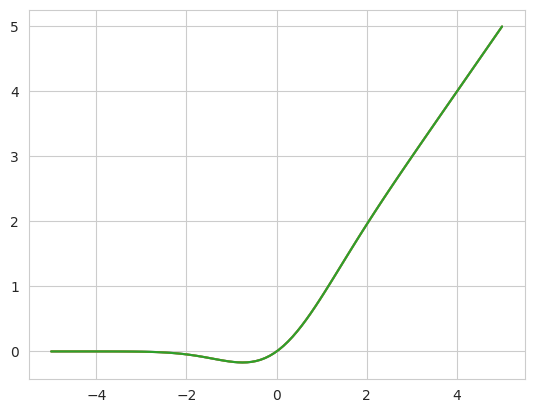

In [ ]:
!pip install -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import torch

sns.set_style("whitegrid")

x = torch.linspace(-5, 5, 100)
plt.plot(x.numpy(), gelu1(x).numpy());
plt.plot(x.numpy(), gelu2(x).numpy());
plt.plot(x.numpy(), gelu3(x).numpy());

# Transformer Hyperparameters

The following class contains all the architectural constants we will need for this notebook. They will be explained in the following sections.

In [ ]:
from typing import NamedTuple

class TransformerConfig(NamedTuple):
  num_pos_embeddings: int = 512
  num_token_type_embeddings: int = 2
  """
  The number of attention heads per encoder layer.
  """
  num_heads: int = 12
  """
  The number of layers in the encoder stack.
  """
  num_layers: int = 12
  """
  The dimensions of value vectors, $d_v$.
  Note that h*d_v = d_{model}
  """
  value_dim: int = 64
  """
  The dimensions of key vectors, $d_k$
  """
  key_dim: int = 64
  """
  The model dimension, $d_{model}$
  """
  model_dim: int = 768
  inner_dim: int = 3072
  """
  The number of words in the tokenizer's vocabulary.
  """
  vocab_size: int = 30522

# WordPiece Tokenization

## Encoding and Decoding Algorithm
As the name may suggest, WordPiece tokenization operates on a word-level. That is, the input text is first normalized (lowercased in our case) and split into words by splitting at spaces and discarding empty words. Then, for every word, the longest matching vocabulary term is found. For example, consider a vocabulary consisting of `a` (id: 0) and `aa` (id: 1). The input sentence `"a aa"` should be tokenized into `[0, 1]`. Some words may however consist of multiple tokens, here the *continuation prefix* comes into play. For BERT, this is `##` and is used to denote that the token is part of the same word as the previous. Consider the vocabulary from before but with the additional token `##a` (id: 2). The input `"aaaa"` will be considered to contain the following tokens: `aa ##a ##a` and thus should be tokenized to `[1, 2, 2]`.

Finally, BERT expects *special tokens* to be added at the beginning (`[CLS]`) and end (`[SEP]`) of any input.

## Questions
1. What datastructure may be well suited for a WordPiece tokenizer?
2. What runtime complexity does WordPiece tokenization have with a well chosen datastructure?
3. What do you think may happen if a word cannot be tokenized? For example, with the vocabulary above, how should `aac` be tokenized?

In [ ]:
# Install pygtrie (https://pygtrie.readthedocs.io/en/latest/index.html)
!pip -q install pygtrie

import requests

# Download and parse the configuration from Hugging Face
req = requests.get('https://huggingface.co/google-bert/bert-base-uncased/raw/main/tokenizer.json?download=true')
config = req.json()

vocab = config["model"]["vocab"]
print(f"The vocabulary contains {len(vocab)} tokens")
print(f"Tokens 100 to 110 in the vocabulary: {list(vocab.keys())[100:110]}")

The vocabulary contains 30522 tokens
Tokens 100 to 110 in the vocabulary: ['[UNK]', '[CLS]', '[SEP]', '[MASK]', '[unused99]', '[unused100]', '[unused101]', '[unused102]', '[unused103]', '[unused104]']


In [ ]:
import pygtrie

import re
from typing import Iterable


class Tokenizer:
  """
  Implements a rudimentary WordPiece tokenizer.
  """

  def __init__(self, vocab: dict[str, int]) -> None:
    self._trie = pygtrie.CharTrie({k.lower(): v for k,v in vocab.items()})
    self._begin_seq_id = vocab["[CLS]"]
    self._end_seq_id = vocab["[SEP]"]
    self._id_to_tok = {v: k for k, v in vocab.items()}
    self._continuing_subword_prefix = "##"

  def __encode_word(self, word: str) -> Iterable[int]:
    """
    Encode the word by repeatedly matching the longest prefix in the vocabulary.
    """
    while word != self._continuing_subword_prefix:
      prefix, id = self._trie.longest_prefix(word)
      word = self._continuing_subword_prefix+word[len(prefix):]
      yield id

  def encode(self, input: str) -> Iterable[int]:
    """
    Encodes the input sentence in the following steps:
    1. Pretokenize the input by splitting at whitespaces and special characters
       E.g., "AB C!" will be split to ["AB", "C", "!"]
    2. Encode every word by greedily matching the longest prefix from the
       vocabulary.
    3. Return a sequence of all token-ids in order, prepended with the begin
       sequence token and end sequence token.
    """
    # Lowercase and presplit words:
    words = re.findall(r"\[mask\]|\w+|[^\w\s]+", input.lower())
    # Convert each word into a sequence of tokens:
    yield self._begin_seq_id
    for word in words:
      yield from self.__encode_word(word)
    yield self._end_seq_id

  def decode(self, tokenids: list[int]) -> list[str]:
    words: list[str] = []
    for tokenid in tokenids:
      token = self._id_to_tok[tokenid]
      if token.startswith(self._continuing_subword_prefix):
        words[-1] += token[2:]
      else:
        words.append(token)
    return words


In [ ]:
tokenizer = Tokenizer(vocab)
tokens = list(tokenizer.encode("This [MASK] the way!"))
print(tokens)
if tokens == [ 101, 2023,  103, 1996, 2126,  999,  102]:
  print("Tokenization seems to work!")
else:
  print("Something is off with the tokenizer :(")

print(f"The decoded text is: >{' '.join(tokenizer.decode(tokens))}<")
print(f"The decoded text is: >{' '.join(tokenizer.decode(tokenizer.encode('321az gadiugv 812t3784 178g')))}<")

[101, 2023, 103, 1996, 2126, 999, 102]
Tokenization seems to work!
The decoded text is: >[CLS] this [MASK] the way ! [SEP]<
The decoded text is: >[CLS] 321az gadiugv 812t3784 178g [SEP]<


#### Further Reading
- Webis' NLP Lecture on [Byte-Pair Encoding](https://downloads.webis.de/lecturenotes/natural-language-processing/unit-en-text-preprocessing.pdf#page=37).
- Hugging Face has a nice course on how WordPiece tokenizers are trained: [LLM Course &ndash; WordPiece Tokenization](https://hf.co/learn/llm-course/chapter6/6)
- Xinying Song, Alex Salcianu, Yang Song, Dave Dopson, and Denny Zhou. 2021. [Fast WordPiece Tokenization](https://aclanthology.org/2021.emnlp-main.160.pdf). In *Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing*, pages 2089–2103, Online and Punta Cana, Dominican Republic. Association for Computational Linguistics.

# Reimplementing BERT

This section will teach you how BERT works and how you can reimplement it. Note that *reimplementing* BERT is a far easier task than *training* BERT. Run the following cell to download a pre-trained BERT model.

In [ ]:
!wget -qk https://huggingface.co/google-bert/bert-base-uncased/resolve/main/model.safetensors?download=true -O "./model.safetensors"

## Preliminary Jank

To load our model from the Hugging Face `bert-base-uncased` checkpoint later, we need to have the same names for our submodules as Hugging Face uses. Because this should not be a major issue in this notebook, we will initialize all submodules for you. This also means that we need the following redefinition of `LayerNorm` since PyTorch uses the names `bias` and `weight` for their weights but Hugging Face checkpoints use `beta` and `gamma`. All the following code does, is remapping these parameters.

In [ ]:
from torch.nn import LayerNorm

class HFLayerNorm(LayerNorm):
  """
  PyTorch's layernorm uses the parameter names `weight` and `bias`. Hugging Face
  does not, so, to load our BERT model from a Hugging Face checkpoint later on,
  we must re-register these parameters as `gamma` and `beta`.
  """
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.register_parameter("beta", self.bias)
    self.register_parameter("gamma", self.weight)


## The Embedding Layer

After the text has been tokenized, we now need to map these tokens into vector representations. The transformer architecture, and by extension BERT, does so by learning static token embeddings (called *word embeddings*), which are analogous to what we have seen above with word2vec. To further encode positional information into the input, a *positional encoding* is added to each *word embedding*. The positional ecoding (which Hugging Face calls *position embedding*) only depends on the index of the word and is usually precomputed and stored with the trained model though it is not a trainable parameter.

Let $(w_i)_{i=1}^s \subseteq \mathbb{N}$ be the input sequence of size $s$, where $w_i$ is the token id of the $i$-th token, the output of the embedding layer is
$$\operatorname{Embed}\colon \mathbb{N}^{\mathbb{N}}\to (\mathbb{R}^{d_\text{model}})^\mathbb{N} \quad\text{via}\quad (w_i)_{i=1}^s \mapsto (\operatorname{PE}(i) + \operatorname{WE}(w_i))_{i=1}^s,$$
where $\operatorname{PE}(i)$ is the positional encoding at index $i$ and $\operatorname{WE}(x)$ is the word embedding of the token $x$ respectively.

**Note:** BERT additional introduces *token type embeddings*. However, these are unused so that we will ignore them. To ignore them, we simply add the token type embedding of the token type *0* to every embedding.

In [ ]:
from torch import Tensor, arange
from torch.nn import Module, Embedding

class BERTEmbedding(Module):
  def __init__(self, config: TransformerConfig) -> None:
    super().__init__();
    self.position_embeddings = Embedding(config.num_pos_embeddings, config.model_dim)
    self.token_type_embeddings = Embedding(config.num_token_type_embeddings, config.model_dim)
    self.word_embeddings = Embedding(config.vocab_size, config.model_dim)
    self.LayerNorm = HFLayerNorm(config.model_dim)

  def forward(self, input_ids: Tensor) -> Tensor:
    posemb = self.position_embeddings(arange(0, input_ids.shape[-1]));
    inpemb = self.word_embeddings(input_ids);
    # We ignore the token types here by setting all to use the 0 type
    tokemb = self.token_type_embeddings(torch.zeros_like(input_ids))
    return self.LayerNorm(inpemb + tokemb + posemb);

## Encoder Layers

### Attention

The *Multi-Head Attention (mha)* layer is at the heart of the transformer architecture (and the **attention** part in _**Attention** is all you need_). Intuitively, the idea behind transformers and attention is that the static embeddings from the embedding layer are iteratively refined based on the *context*. Each of the encoder layers has multiple attention heads that update the token representation as a weighted average over the context words. The *weights* can be thought of as how much each context token influences the token, i.e., how much *attention* does the token pay to each context token. [Clark et al. (2019)](https://aclanthology.org/W19-4828/) observed that some of these attention patterns can be interpreted syntactically, such as determiners (the, this, a, my, ...) attending to their nouns or coreferences attending to their early occurence (*antecedent*). You can explore this on the interactive explorable BERT ([exBERT](https://huggingface.co/spaces/exbert-project/exbert)) website. Have a look, for example at head 7 in the 4th encoder layer for coreferences.

Mathematically, this attention value is calculated by applying three linear transformation to each token: The query $\mathbf{W}_i^Q$, key $\mathbf{W}_i^K$, and value $\mathbf{W}_i^V$ transformation. _**Note:** BERT additionally adds biases to each of these operations but this is not part of the original Transformer description and does not improve effectiveness of the architecture._ These linear transformations result in query and key matrices $\mathbf{Q}, \mathbf{K}\in \mathbb{R}^{s\times d_k}$ and a value matrix $\mathbf{V}\in\mathbb{R}^{s\times d_v}$, which are usually interpreted to hold abstract information about the information "asked for" ($\mathbf{Q}$) and "provided" ($\mathbf{K}$) by a token. As such, to have a high attention between the word at position $m$ and at position $n$, the query vector of token $m$ and key vector of token $n$ must be similar. Similarity, here is the inner product between each query- and key vector, calculated as $\mathbf{Q}\times\mathbf{K}^\top \in \mathbf{R}^{s\times s}$. To avoid numerical instabilities, the attention scores are *scaled* by $\sqrt{d_k}$ and additionally *normalized* to form a probability distribution that sums up to 1 using $\operatorname{softmax}$. The result is an $s\times s$ attention matrix, where the entries of each row sum to $1$. These are then used to update the token representations as the weighted average of their *values* $\mathbf{V}$:

$$\operatorname{sdpa}\colon \mathbb{R}^{s\times d_k} \times \mathbb{R}^{s\times d_k} \times \mathbb{R}^{s\times d_v}\to \mathbb{R}^{s\times d_v} \quad\text{via}\quad \mathbf{Q}, \mathbf{K}, \mathbf{V} \mapsto \operatorname{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right)\mathbf{V}.$$

This process is called *scaled dot product attention (sdpa)* and is performed $h$ times in parallel and then aggregated to form multi-head attention:

$$\operatorname{mha}\colon \mathbb{R}^{s\times d_\text{model}}\to\mathbb{R}^{s\times d_\text{model}} \quad\text{via}\quad x \mapsto \operatorname{concat}\big(\big(\operatorname{sdpa}\big(x\mathbf{W}_i^Q+b_i^Q, x\mathbf{W}_i^K+b_i^K, x\mathbf{W}_i^Y+b_i^Y\big)\big)_{i=1}^h\big) \mathbf{W}^O + b^O.$$
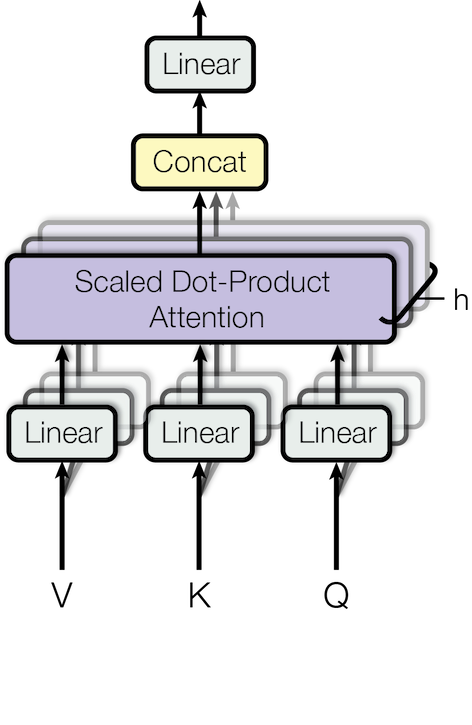

### Encoder
With multi-head attention out of the way, the hard parts are behind us. What remains is an additional feed forward network and two residual connections ([He et al., 2016](https://ieeexplore.ieee.org/document/7780459)) to form an encoder layer:

$$
\begin{align}
\operatorname{mha-residual}\colon \mathbb{R}^{s\times d_\text{model}}\to\mathbb{R}^{s\times d_\text{model}} & \quad\text{via}\quad x \mapsto \operatorname{LayerNorm}(\operatorname{mha}(x)+x)\\
\operatorname{ffn-residual}\colon \mathbb{R}^{s\times d_\text{model}}\to\mathbb{R}^{s\times d_\text{model}} & \quad\text{via}\quad x \mapsto \operatorname{LayerNorm}(\operatorname{gelu}(x\mathbf{W}^I+b^I)\mathbf{W}^{O'}+b^{O'} + x)\\
\operatorname{encoder}\colon \mathbb{R}^{s\times d_\text{model}}\to\mathbb{R}^{s\times d_\text{model}} & = \operatorname{ffn-redisual}\circ\operatorname{mha-residual}
\end{align}
$$
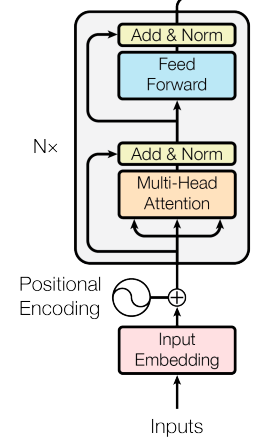

In [ ]:
from torch.nn import Module, Linear, LayerNorm, ModuleDict
from torch import Tensor
from torch.nn.functional import softmax
import math

class TransformerEncoder(Module):

  def __init__(self, config: TransformerConfig) -> None:
    """
    Initializes the weights for the transformer model. The trickiest part here
    is to keep the same names as the Hugging Face transformer checkpoints.
    """
    super().__init__()
    self.config = config
    # We already initialize all submodules for you here and you can simply
    # access them like you would with member variabels. For example, to access
    # the self-attention key matrix, you can use `self.attention.self.key`.
    self.add_module("attention", ModuleDict({
              "self": ModuleDict({
                  "key": Linear(self.config.model_dim, self.config.num_heads * self.config.key_dim),
                  "query": Linear(self.config.model_dim, self.config.num_heads * self.config.key_dim),
                  "value": Linear(self.config.model_dim, self.config.num_heads * self.config.value_dim),
                  }),
              "output": ModuleDict({
                  "dense": Linear(self.config.num_heads * self.config.value_dim, self.config.model_dim),
                  "LayerNorm": HFLayerNorm(self.config.model_dim),
              })
            })
    )
    self.add_module("intermediate", ModuleDict({
        "dense": Linear(self.config.model_dim, self.config.inner_dim)
    }))
    self.add_module("output", ModuleDict({
        "dense": Linear(self.config.inner_dim, self.config.model_dim),
        "LayerNorm": HFLayerNorm(self.config.model_dim)
    }))

  def scaled_dot_product_attention(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    """
    Calculate the scaled dot product attention (sdpa) of the given query, key,
    and value tensors. Each tensor has at least rank 2 with the last two
    dimensions beeing the sequence length (s), and number of attention heads
    times the respective dimension (h*d), where d is self.config.key_dim for key
    and query and self.config.value_dim for value. The output should have the
    same rank as the input and the same shape as the value tensor.
    """
    # Hint: if we transpose the tensors such that the heads are at the third
    # last dimension, we can compute sdpa for all heads within the same tensor-
    # operation
    facq = rearrange(query, "... s (h d) ->... h s d", h=self.config.num_heads)
    fack = rearrange(key, "... s (h d) ->... h s d", h=self.config.num_heads)
    facv = rearrange(value, "... s (h d) ->... h s d", h=self.config.num_heads)
    # Compute softmax((QK^T) / sqrt(d_k)) * V
    attn = softmax((facq @ fack.transpose(-1, -2)) / math.sqrt(self.config.key_dim), -1) @ facv
    return rearrange(attn, "... h s d -> ... s (h d)")

  def multi_head_attention(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    return self.attention.output.dense(self.scaled_dot_product_attention(query, key, value))

  def forward(self, input: Tensor) -> Tensor:
    mha = self.multi_head_attention(self.attention.self.query(input), self.attention.self.key(input), self.attention.self.value(input));
    attention = self.attention.output.LayerNorm(mha + input);
    intermed = gelu(self.intermediate.dense(attention));
    return self.output.LayerNorm(self.output.dense(intermed) + attention);

#### Further Reading
- Kevin Clark, Urvashi Khandelwal, Omer Levy, and Christopher D. Manning. 2019. [What Does BERT Look at? An Analysis of BERT's Attention](https://aclanthology.org/W19-4828/). In *Proceedings of the 2019 ACL Workshop BlackboxNLP: Analyzing and Interpreting Neural Networks for NLP*, pages 276–286, Florence, Italy. Association for Computational Linguistics.

## Bringing it all together: BERT and MLM Decoding

The previous sections described and implemented the embedding and encoder layers. What remains is to bring these together and form BERT. Let $\operatorname{embed}$ be BERT's embedding function as defined above, and $\operatorname{encoder}_i$ denotes the $i$-th encoder layer for $1\leq i\leq \ell$, where $\ell$ is the number of encoding layers (a hyper parameter of the architecture). BERT is the sequential application of each of these functions:
$$\operatorname{BERT}\colon x\mapsto \operatorname{encoder}_\ell(\dots \operatorname{encoder}_1(\operatorname{embed}(x)))$$

In [ ]:
from torch import Tensor
from torch.nn import Embedding, Module, ModuleDict, Parameter, Sequential

class BERT(Module):
  def __init__(self, config: TransformerConfig) -> None:
    super().__init__()
    self.embeddings = BERTEmbedding(config)
    self.register_module("encoder", ModuleDict({"layer": Sequential(*(TransformerEncoder(config) for _ in range(config.num_layers)))}))

  def forward(self, input: Tensor) -> Tensor:
    embeds = self.embeddings(input)
    return self.encoder.layer(embeds)

## Masked Language Modeling (MLM)

Finally, we want to see BERT in action and do something with it but before we do, let us first consider the task that BERT is trained on. Recall continuous bag of words modelling from the introduction, where the model is given a context and should predict the word "in the middle". And interesting observation is that the static embeddings trained in this way are not only effective at the task that they are trained for, which would be rather pointless, but are also proficient at capturing semantics such as how different words relate. As such, it makes sense to translate this task into the transformer domain. One such task is *masked language modeling (MLM)*.

**Masked Language Modeling** gives each token at 15% chance to be selected and multiple tokens may be selected. Each selected token is then replaced with a special `[MASK]` token ("masked out") with an 80% probability, or replaced with a random word (10% probability), or kept as is (10% probability). The model is then tasked with reconstructing all selected tokens.

Since BERT is trained on this task, we can recreate its decoder layer, which applies a linear transformation to BERT's output and then calculates the similarity between each output vector and the token embeddings, a $d_\text{model}\times v$ matrix, where $v$ is the vocabulary size. Ideally, for every token, the token with the highest inner product to the contextual embedding should be same token as in the unmodified input.

## Questions
1. What is the difference between a token being selected and left unchanged and a token not being selected?

In [ ]:
class MLMDecoder(Module):
  def __init__(self, config: TransformerConfig, embeddings: BERTEmbedding) -> None:
    super().__init__()
    self.add_module("predictions", ModuleDict({
        "transform": ModuleDict({
            "dense": Linear(config.model_dim, config.model_dim),
            "LayerNorm": HFLayerNorm(config.model_dim),
        }),
    }))
    self.predictions.register_parameter("bias", Parameter(torch.zeros(config.vocab_size)))
    self.embeddings = [embeddings]  # Don't register these as a submodule

  def forward(self, input: Tensor) -> Tensor:
    transformed = self.predictions.transform.LayerNorm(gelu(self.predictions.transform.dense(input)))
    return transformed @ self.embeddings[0].word_embeddings.weight.T + self.predictions.bias

class BERTMLM(Module):
  def __init__(self) -> None:
    super().__init__();
    self.config = TransformerConfig()
    self.bert = BERT(self.config)
    self.cls = MLMDecoder(self.config, self.bert.embeddings)

  def forward(self, input: Tensor) -> Tensor:
    return self.cls(self.bert(input))

## Testing it all

Finally, we can combine all of the above to check that our output matches the Hugging Face BERT reference implementation and see if BERT gives fitting outputs if we pass it a cloze such as `This [MASK] the way!`.

The following code cell initializes the Hugging Face BERT model and calculates its outputs.

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

hftok = AutoTokenizer.from_pretrained("bert-base-uncased")
hfbert = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

input_ids = hftok("This [MASK] the way!", return_tensors="pt").input_ids

hfout = hfbert(input_ids).logits
print("================================")
print("Output by the HF implementation:")
print(hfout)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Output by the HF implementation:
tensor([[[ -6.6970,  -6.6549,  -6.6774,  ...,  -6.0279,  -5.8682,  -4.0572],
         [-15.1445, -14.9616, -14.9885,  ..., -14.4125, -12.3173,  -9.9740],
         [ -8.8521,  -9.0771,  -8.9349,  ...,  -8.5388,  -6.2250,  -5.0249],
         ...,
         [-11.8810, -12.0242, -11.6084,  ..., -10.4685,  -9.6563,  -9.2717],
         [-12.5029, -12.7621, -12.8687,  ..., -11.8793, -11.7760,  -6.8052],
         [ -9.5091,  -9.5710,  -9.6611,  ...,  -7.6633,  -8.5134,  -7.3767]]],
       grad_fn=<ViewBackward0>)


And now for our own implementation...

In [ ]:
import torch
from safetensors.torch import load_model

tokenizer = Tokenizer(vocab)
input_ids = [list(tokenizer.encode("This [MASK] the way!"))]

bert = BERTMLM()
load_model(bert, "./model.safetensors", strict=False)
logits = bert(torch.tensor(input_ids))
masked_idx = torch.where(torch.tensor(input_ids) == 103)[1]
masked_logits = logits[0, masked_idx, :]
masked_prob = torch.nn.functional.softmax(masked_logits, dim=-1)

print("================================")
print("Output by our implementation:")
print(logits)
if torch.allclose(hfout, logits, atol=1e-2):
  print("Matches the HF implementation!")
else:
  print("Does not match the HF implementation :(")

k = 3
print()
print(f"Top {k} words to fill in the [MASK]:")
for token in torch.topk(masked_logits, k, dim=1).indices[0]:
  tokens = input_ids[0][1:int(masked_idx)] + [int(token)] + input_ids[0][int(masked_idx)+1:-1]
  words = tokenizer.decode(tokens)
  print(f"- [{masked_prob[0][token]*100:>4.1f}%] {' '.join(words)}")

Output by our implementation:
tensor([[[ -6.6969,  -6.6547,  -6.6772,  ...,  -6.0278,  -5.8680,  -4.0570],
         [-15.1448, -14.9618, -14.9887,  ..., -14.4128, -12.3172,  -9.9750],
         [ -8.8520,  -9.0769,  -8.9348,  ...,  -8.5384,  -6.2248,  -5.0254],
         ...,
         [-11.8809, -12.0241, -11.6084,  ..., -10.4687,  -9.6568,  -9.2712],
         [-12.5036, -12.7627, -12.8693,  ..., -11.8796, -11.7763,  -6.8077],
         [ -9.5086,  -9.5706,  -9.6606,  ...,  -7.6631,  -8.5133,  -7.3766]]],
       grad_fn=<AddBackward0>)
Matches the HF implementation!

Top 3 words to fill in the [MASK]:
- [73.8%] this is the way !
- [26.1%] this was the way !
- [ 0.0%] this s the way !


## Further Challenges
These additional tasks are not part of the notebook but feel free to challenge yourself and implement them.

1. **Unknown Tokens:** Our tokenizer does not yet handle the case that a word cannot be tokenized. WordPiece tokenization handles untokenizable words by tokenizing them as the special token `[UNK]`. Note that the entire word must be tokenized as `[UNK]`. For example `aac` in the example above would not be tokenized as `aa [UNK]` but as `[UNK]`.
2. **Masking:** So far, we can only input a single input sequence of multiple input sequences of the same length into our model. If we input two sequences of different lengths, then one of them would produce garbage outputs since tokens attend to undefined (or padding tokens, `[PAD]`, which have to be implemented) beyond the sequence length. This is avoidable through *attention masking*. An attention mask is a boolean tensor that is `True` for every valid token. E.g., the two sequences `a b` and `a b c` could be batched as the input id tensor of shape $2\times 3$ (ignoring `[CLS]` and `[SEP]` for now) and the attention mask
$$\begin{pmatrix}\texttt{True}&\texttt{True}&\texttt{False}\\\texttt{True}&\texttt{True}&\texttt{True}\end{pmatrix}.$$
You can then either pass the mask for every operation and modify attention to respect this by setting masked-out values in the attention matrix to a very small (negative) number (this is currently what Hugging Face does) or use PyTorch's [masked tensors](https://docs.pytorch.org/tutorials/prototype/maskedtensor_overview) (experimental).